In [16]:

import os
import sys
import re
import matplotlib
import pandas as pd
import numpy as np
from os.path import splitext
import ipaddress as ip
import tldextract
import whois
import datetime
from urllib.parse import urlparse
import ipaddress as ip
import sklearn.ensemble as ek
from sklearn import tree, linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from  sklearn.metrics  import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import io



In [14]:
from google.colab import files 
  
  
uploaded = files.upload()


Saving URL_dataset.csv to URL_dataset.csv


In [18]:

df = pd.read_csv(io.BytesIO(uploaded['URL_dataset.csv'])) ; 
df = df.sample(frac=1).reset_index(drop=True)
print("Total records: ",len(df))
df.head()



Total records:  7030


,URL,Lable
0,http://www.dicolympic.com/,0
1,http://www.londonlibrary.co.uk/,0
2,http://www.personal.kent.edu/~rmuhamma/OpSyste...,0
3,http://hprocess.0fees.us/webs/,1
4,http://lapanmaret.co.nf/m1.php,1


In [25]:
# Method to count number of dots
def countdots(url):  
    return url.count('.')

# Method to count number of delimeters
def countdelim(url):
    count = 0
    delim=[';','_','?','=','&']
    for each in url:
        if each in delim:
            count = count + 1    
    return count

#method to check the presence of hyphens
def isPresentHyphen(url):
    return url.count('-')

#method to check the presence of @
def isPresentAt(url):
    return url.count('@')

def isPresentDSlash(url):
    return url.count('//')

def countSubDir(url):
    return url.count('/')

def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))

def countQueries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))
    
def get_ext(url):
    root, ext = splitext(url)
    return ext

# Is IP addr present as th hostname, let's validate
def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0


In [26]:

Suspicious_TLD=['zip','cricket','link','work','party','gq','kim','country','science','tk']
Suspicious_Domain=['luckytime.co.kr','mattfoll.eu.interia.pl','trafficholder.com','dl.baixaki.com.br','bembed.redtube.comr','tags.expo9.exponential.com','deepspacer.com','funad.co.kr','trafficconverter.biz']

featureSet = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at','presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD','presence of suspicious domain','label'))


In [27]:

def getFeatures(url, label): 
    result = []
    url = str(url)
    
    #add the url to feature set
    result.append(url)
    
    #parse the URL and extract the domain information
    path = urlparse(url)
    ext = tldextract.extract(url)
    
    #counting number of dots in subdomain    
    result.append(countdots(ext.subdomain))
    
    #checking hyphen in domain   
    result.append(isPresentHyphen(path.netloc))
    
    #length of URL    
    result.append(len(url))
    
    #checking @ in the url    
    result.append(isPresentAt(path.netloc))
    
    #checking presence of double slash    
    result.append(isPresentDSlash(path.path))
    
    #Count number of subdir    
    result.append(countSubDir(path.path))
    
    #number of sub domain    
    result.append(countSubDomain(ext.subdomain))
    
    #length of domain name    
    result.append(len(path.netloc))
    
    #count number of queries    
    result.append(len(path.query))
    
    #Adding domain information
    
    #if IP address is being used as a URL     
    result.append(isip(ext.domain))
    
    #presence of Suspicious_TLD
    result.append(1 if ext.suffix in Suspicious_TLD else 0)
    
    #presence of suspicious domain
    result.append(1 if '.'.join(ext[1:]) in Suspicious_Domain else 0 )
    
    result.append(str(label))
    return result



In [28]:

for i in range(len(df)):
    features = getFeatures(df["URL"].loc[i], df["Lable"].loc[i])    
    featureSet.loc[i] = features


In [29]:
featureSet.head()

,url,no of dots,presence of hyphen,len of url,presence of at,presence of double slash,no of subdir,no of subdomain,len of domain,no of queries,is IP,presence of Suspicious_TLD,presence of suspicious domain,label
0,http://www.dicolympic.com/,0,0,26,0,0,1,1,18,0,0,0,0,0
1,http://www.londonlibrary.co.uk/,0,0,31,0,0,1,1,23,0,0,0,0,0
2,http://www.personal.kent.edu/~rmuhamma/OpSyste...,1,0,56,0,0,3,2,21,0,0,0,0,0
3,http://hprocess.0fees.us/webs/,0,0,30,0,0,2,1,17,0,0,0,0,1
4,http://lapanmaret.co.nf/m1.php,0,0,30,0,0,1,1,16,0,0,0,0,1


In [30]:


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Length of URL')

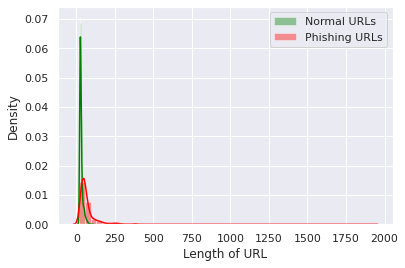

In [31]:

sns.set(style="darkgrid")
sns.distplot(featureSet[featureSet['label']=='0']['len of url'],color='green',label='Normal URLs')
sns.distplot(featureSet[featureSet['label']=='1']['len of url'],color='red',label='Phishing URLs')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')


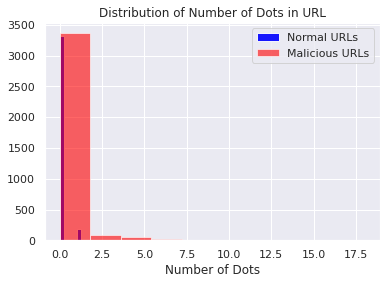

In [32]:

x=featureSet[featureSet['label']=='0']['no of dots']
y=featureSet[featureSet['label']=='1']['no of dots']
plt.hist(x,bins=8, alpha=0.9, label='Normal URLs',color='blue')
plt.hist(y,bins=10, alpha=0.6, label='Malicious URLs',color='red')
plt.legend(loc='upper right')
plt.xlabel('Number of Dots')
plt.title('Distribution of Number of Dots in URL')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Length of Domain/Host')

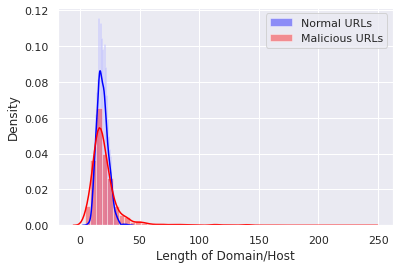

In [33]:

sns.set(style="darkgrid")
sns.distplot(featureSet[featureSet['label']=='0']['len of domain'],color='blue',label='Normal URLs')
sns.distplot(featureSet[featureSet['label']=='1']['len of domain'],color='red',label='Malicious URLs')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')

In [34]:
featureSet.groupby(featureSet['label']).size()

label
0    3494
1    3536
dtype: int64

In [35]:

X = featureSet.drop(['url','label'],axis=1).values
y = featureSet['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

Accuracy: 0.8534850640113798
Cross-Validation Score 0.8462004513188752


Text(0.5, 1.0, 'Confusion Matrix')

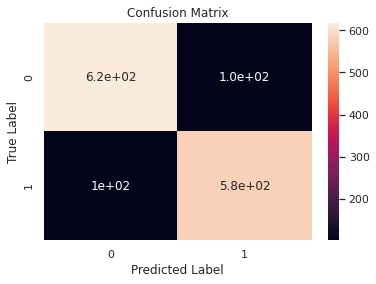

In [36]:

# ## Classification Models

# - Logistic Regression
# - Gaussian Naive Bayes
# - Decision Tree Classifier
# - Random Forest Classifier
# - AdaBoostClassifier

# ### Logistic Regression

# In[116]:


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_predicted = lr.predict(X_test)
lr_acc = accuracy_score(y_test,lr_predicted)
print("Accuracy:",lr_acc)

lr_scores = cross_val_score(lr, X_train, y_train, cv=10)
print('Cross-Validation Score', lr_scores.mean())

conf_matrix = confusion_matrix(y_test, lr_predicted)
sns.heatmap(conf_matrix,annot=True,cbar=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [37]:


confusion_matrix(y_test, lr_predicted)

tp_lr = confusion_matrix(y_test, lr_predicted)[0,0]
fp_lr = confusion_matrix(y_test, lr_predicted)[0,1]
tn_lr = confusion_matrix(y_test, lr_predicted)[1,1]
fn_lr = confusion_matrix(y_test, lr_predicted)[1,0]

precison_lr = tp_lr/(tp_lr+fp_lr)
recall_lr = tp_lr/(tp_lr+fn_lr)

print("Precision: ", precison_lr)
print("Recall: ", recall_lr)


Precision:  0.8547717842323651
Recall:  0.8595271210013908


In [38]:


GNB = GaussianNB()
GNB.fit(X_train, y_train)
GNB_predicted = GNB.predict(X_test)
GNB_acc = accuracy_score(y_test,GNB_predicted)
print("Accuracy:",GNB_acc)

GNB_scores = cross_val_score(GNB, X_train, y_train, cv=10)
print('Cross-Validation Score', GNB_scores.mean())

Accuracy: 0.6806543385490754
Cross-Validation Score 0.662704563124593


In [39]:

confusion_matrix(y_test, GNB_predicted)


array([[705,  18],
       [431, 252]])

In [40]:


tp_GNB = confusion_matrix(y_test, GNB_predicted)[0,0]
fp_GNB = confusion_matrix(y_test, GNB_predicted)[0,1]
tn_GNB = confusion_matrix(y_test, GNB_predicted)[1,1]
fn_GNB = confusion_matrix(y_test, GNB_predicted)[1,0]

precison_GNB = tp_GNB/(tp_GNB+fp_GNB)
recall_GNB = tp_GNB/(tp_GNB+fn_GNB)

print("Precision: ", precison_GNB)
print("Recall: ", recall_GNB)

Precision:  0.975103734439834
Recall:  0.6205985915492958


In [41]:

DTC = tree.DecisionTreeClassifier(max_depth=10)
DTC.fit(X_train, y_train)
DTC_predicted = DTC.predict(X_test)
DTC_acc = accuracy_score(y_test,DTC_predicted)
print("Accuracy:",DTC_acc)

DTC_scores = cross_val_score(DTC, X_train, y_train, cv=10)
print('Cross-Validation Score', DTC_scores.mean())


Accuracy: 0.8940256045519204
Cross-Validation Score 0.887987585570438


In [42]:

confusion_matrix(y_test, DTC_predicted)


array([[632,  91],
       [ 58, 625]])

In [43]:

tp_DTC = confusion_matrix(y_test, DTC_predicted)[0,0]
fp_DTC = confusion_matrix(y_test, DTC_predicted)[0,1]
tn_DTC = confusion_matrix(y_test, DTC_predicted)[1,1]
fn_DTC = confusion_matrix(y_test, DTC_predicted)[1,0]

precison_DTC = tp_DTC/(tp_DTC+fp_DTC)
recall_DTC = tp_DTC/(tp_DTC+fn_DTC)

print("Precision: ", precison_DTC)
print("Recall: ", recall_DTC)


Precision:  0.8741355463347165
Recall:  0.9159420289855073


In [44]:

RFC = ek.RandomForestClassifier(max_depth=10)
RFC.fit(X_train, y_train)
RFC_predicted = RFC.predict(X_test)
RFC_acc = accuracy_score(y_test,RFC_predicted)
print("Accuracy:",RFC_acc)

RFC_scores = cross_val_score(RFC, X_train, y_train, cv=10)
print('Cross-Validation Score', RFC_scores.mean())


Accuracy: 0.9068278805120911
Cross-Validation Score 0.9000768000606815


In [45]:

confusion_matrix(y_test, RFC_predicted)

array([[644,  79],
       [ 52, 631]])

In [46]:


tp_RFC = confusion_matrix(y_test, RFC_predicted)[0,0]
fp_RFC = confusion_matrix(y_test, RFC_predicted)[0,1]
tn_RFC = confusion_matrix(y_test, RFC_predicted)[1,1]
fn_RFC = confusion_matrix(y_test, RFC_predicted)[1,0]

precison_RFC = tp_RFC/(tp_RFC+fp_RFC)
recall_RFC = tp_RFC/(tp_RFC+fn_RFC)

print("Precision: ", precison_RFC)
print("Recall: ", recall_RFC)



Precision:  0.8907330567081605
Recall:  0.9252873563218391


In [47]:


ABC = ek.AdaBoostClassifier(n_estimators=50)
ABC.fit(X_train, y_train)
ABC_predicted = ABC.predict(X_test)
ABC_acc = accuracy_score(y_test,ABC_predicted)
print("Accuracy:",ABC_acc)

ABC_scores = cross_val_score(ABC, X_train, y_train, cv=10)
print('Cross-Validation Score', ABC_scores.mean())



Accuracy: 0.8883357041251778
Cross-Validation Score 0.8751796742160389


In [48]:

confusion_matrix(y_test, ABC_predicted)

array([[631,  92],
       [ 65, 618]])

In [51]:
tp_ABC = confusion_matrix(y_test, ABC_predicted)[0,0]
fp_ABC = confusion_matrix(y_test, ABC_predicted)[0,1]
tn_ABC = confusion_matrix(y_test, ABC_predicted)[1,1]
fn_ABC = confusion_matrix(y_test, ABC_predicted)[1,0]

precison_ABC = tp_ABC/(tp_ABC+fp_ABC)
recall_ABC = tp_ABC/(tp_ABC+fn_ABC)

print("Precision: ", precison_ABC)
print("Recall: ", recall_ABC)


Precision:  0.8727524204702628
Recall:  0.9066091954022989


In [52]:

models = [('Logistic Regression', tp_lr, fp_lr, tn_lr, fn_lr, lr_acc, lr_scores.mean()),
          ('Gaussian Naive Bayes', tp_GNB, fp_GNB, tn_GNB, fn_GNB, GNB_acc, GNB_scores.mean()),
          ('Decision Tree Classifier', tp_DTC, fp_DTC, tn_DTC, fn_DTC, DTC_acc, DTC_scores.mean()),
          ('Random Forest Classifier', tp_RFC, fp_RFC, tn_RFC, fn_RFC, RFC_acc, RFC_scores.mean()),
          ('AdaBoostClassifier', tp_ABC, fp_ABC, tn_ABC, fn_ABC, ABC_acc, ABC_scores.mean()),
         ]

predict = pd.DataFrame(data = models, columns=['Model', 'True Positive', 'False Positive', 'True Negative',
                                               'False Negative', 'Accuracy',
                                               'Cross-Validation'])
predict



,Model,True Positive,False Positive,True Negative,False Negative,Accuracy,Cross-Validation
0,Logistic Regression,618,105,582,101,0.853485,0.846200
1,Gaussian Naive Bayes,705,18,252,431,0.680654,0.662705
2,Decision Tree Classifier,632,91,625,58,0.894026,0.887988
3,Random Forest Classifier,644,79,631,52,0.906828,0.900077
4,AdaBoostClassifier,631,92,618,65,0.888336,0.875180


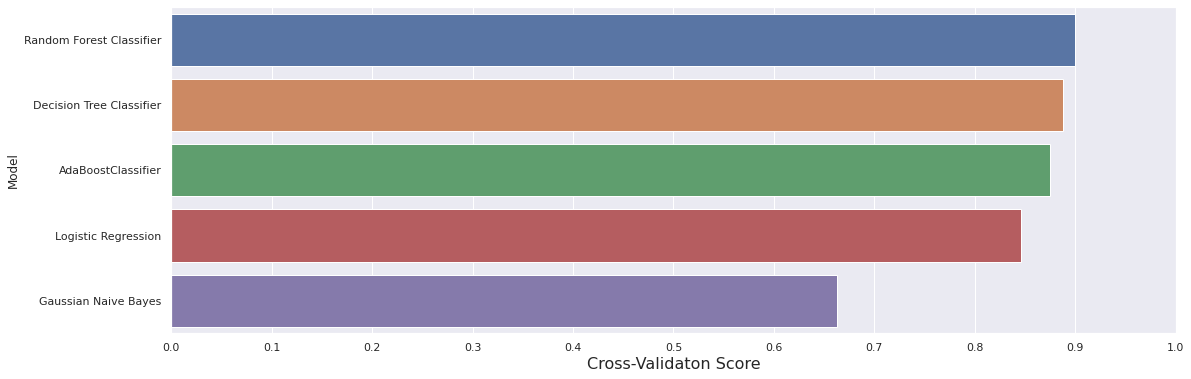

In [54]:

f, axe = plt.subplots(1,1, figsize=(18,6))
predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)
sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
axe.set_xticks(np.arange(0, 1.1, 0.1))
plt.show()